## Agenda

- How do I use the **scikit library** to estimate a logistic regression
- Transform a *categorical* variable into a *numerical* variable
- Estimate a logistic regression *without* penalisation
- Estimate a logistic regression *with* penalisation

### Upload the data and create the variables of interest

Import the original mortgage data which are contained in the "MortgageData.csv" file. The data are imported by using the **pandas liibrary** via the usual command *import pandas as pd* 

In [1]:
import pandas as pd

df = pd.read_csv(r'Default.csv', index_col =0)
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462905
50%,823.636973,34552.644800
75%,1166.308387,43807.729275
max,2654.322576,73554.233500


In [3]:
df.head()

,default,student,balance,income
id,,,,
1,No,No,729.526495,44361.62507
2,No,Yes,817.180407,12106.13470
3,No,No,1073.549164,31767.13895
4,No,No,529.250605,35704.49394
5,No,No,785.655883,38463.49588


The variable we want to predict here is the **default**. In particular, we want to predict how many times a credit card loan is defaulted based on a large set of individuals in the US. The predictors are the **balance** of account and the **income**. We need first to transform the default variabe from categorical to numerical. 

This can be done in a variety of alternative ways. The one we use here is simply set of a dummy equal to one for when default = YES and zero otherwise. 

In [6]:
import numpy as np

df['default_dummy'] = np.where(df['default'].str.contains('Yes'), 1, 0)

df.tail()

,default,student,balance,income,default_dummy
id,,,,,
9996,No,No,711.555020,52992.37891,0
9997,No,No,757.962918,19660.72177,0
9998,No,No,845.411989,58636.15698,0
9999,No,No,1569.009053,36669.11236,0
10000,No,Yes,200.922183,16862.95232,0


We see that we created a set of dummy variables which coincides with the different categories of the loans. We are interested in the "default_Yes" category, so this dummy variable is going to be our target object we need to predict. 

As predictors we use a set of mortgage characteristics which are in the dataset, such as:

- Balance of account (balance)
- Household income (income)

In order to make the estimates more numerically stable we *rescale* the predictors by divided each series by its standard deviation. To do that we use the command **StandardScaler** from the **sklearn** package. 

In [7]:
from sklearn.preprocessing import StandardScaler

X = df[['balance','income']]
X = StandardScaler(with_mean=True).fit_transform(X)
#standardizing the data
#fit_transform: fit the data and transform them
#with_mean=True: substract mean of the data

y = df['default_dummy']
#define the Y data

Since we wish to predict the default event for a loan out of sample, we need to split the sample of observations between those that will be used for training/validation and those which will be used for testing. This is done using the command **train_test_split**. Let consider a 50% of the observations for the training period and 50% for the testing period. 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
#test_size: how much data assigned to test
#stratify: split the data using stratifies sampling

Notice that since the variable of interest is highly imbalanced, meaning there is only a small fraction of defaulted loans compared to the total amount of observations, we need to "stratify" the splitting, meaning we need to split between training/validation and testing in a way that keeps the proportion of default vs non-default comparable between the sample that is used for training and validation and the sample that is used for testing. 

## Data visualization 

Before estimating the logistic regression we want to have a sense of the nature of the data. We are going to check for two things:

- 1. The heterogeneity of income between students vs non-students and default vs non-default 
- 2. The heterogeneity of account balance between students vs non-students and default vs non-default

To do that we are going to use the package **matplotlib.pyplot** which allows to create a subplot with many different plots in a single figure. 

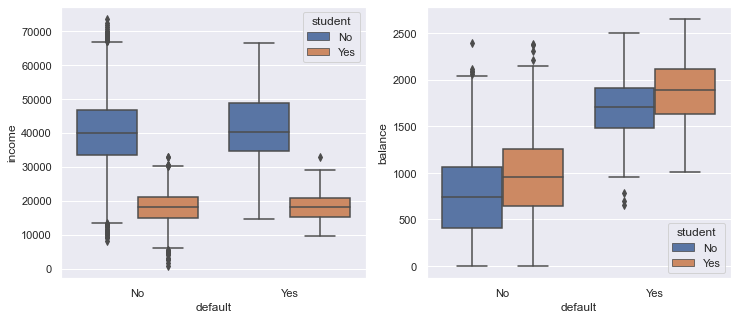

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
#plt.subplots(rows, columns, figsize)

sns.boxplot(ax = axes[0], x="default", y="income", hue="student", data=df)
#hue: categorical variable
sns.boxplot(ax = axes[1], x="default", y="balance", hue="student", data=df)
fig.savefig("boxplots.png") 

<AxesSubplot:xlabel='default', ylabel='income'>

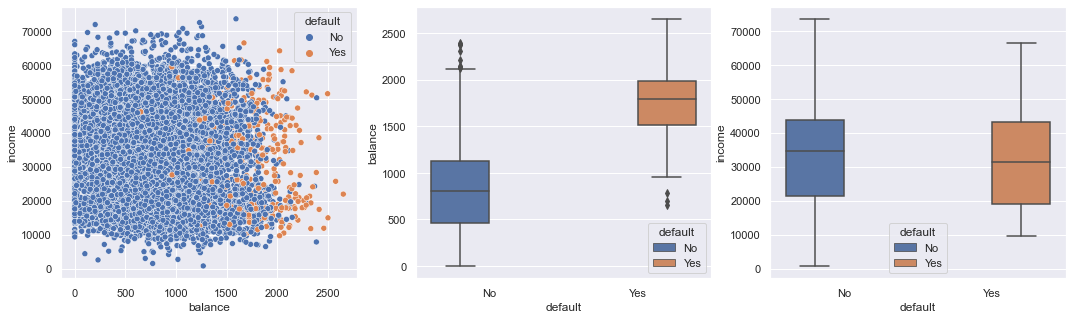

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.scatterplot(ax = axes[0], x="balance", y="income", hue="default", data=df)
sns.boxplot(ax = axes[1], x="default", y="balance", hue="default", data=df)
sns.boxplot(ax = axes[2], x="default", y="income", hue="default", data=df)

## Logistic regression

### Logistic regression without penalty term 

We can estimate our binary logistic regression by using the training/validation dataset and make predictions based on the predictors available for the testing sample

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
#initiaise a LogisticRegression object

model.fit(X_train, y_train)
#fit the model using the training data

LogisticRegression()

Let have a look at the parameters estimates for the logistic regression model 

In [17]:
coef  = model.coef_

# Display the slope coefficients estimates 
# The coefficients
print('Coefficients: \n', model.coef_)

Coefficients: 
 [[2.59704052 0.20177589]]


It seems that there is a positive effect of balance on default, while the effect of income on loan default is positive. 

### Logistic regression with penalty term

We now estimate a Logistic regression with a penalty term that is cross validated by using a 5-fold cross validation procedure. The penalty term *C* represents the inverse of regularization strength; must be a positive float. Smaller values mean stronger regularization.

In [18]:
from sklearn.model_selection import GridSearchCV
import numpy as np

C_space    = np.linspace(0.1, 10, 100) # Here we explore a penalty term from 0.1 to 100
param_grid = {'C': C_space}

logreg_cv  = GridSearchCV(model, param_grid = param_grid, cv = 5) #cv: cross validation folds, i.e. dividing into how many folds to do cross validation
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ])})

In [19]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)

tuned hyperparameters :(best parameters)  {'C': 2.3000000000000003}
